# FRETpredict tutorial (Hsp90)

In [55]:
import MDAnalysis
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pandas as pd
import seaborn as sns
from FRET import FRETpredict
import warnings

warnings.filterwarnings('ignore')

Cartoon representation of the open structure of Hsp90 (apoprotein). Chains A and B are colored in red and blue, respectively. On each chain, the residues that will be used for FRET Efficiency calculations are shown using their Van der Waals radii.

![title](Hsp90_chains.png)

Cartoon representation of the closed structure of Hsp90 (Holo protein, with ATP). Chains A and B are colored in red and blue, respectively. On each chain, the residues that will be used for FRET Efficiency calculations are shown using their Van der Waals radii.

![title](Hsp90_closed_chains.png)

## Single protein structure (Hsp90)

### Single residue pair

Select residues to put the rotamer libraries on and the corresponding experimental data file.

In [2]:
res1 = 452
chain_res1 = 'A'
chromophore_1 = '532'

res2 = 637
chain_res2 = 'B'
chromophore_2 = '647'

exp_data_file = '452_532_637_647N_APO.txt'

Create MDAnalysis.Universe object for the protein (open Hsp90)

In [3]:
u = MDAnalysis.Universe('test_systems/Hsp90/openHsp90.pdb')

Create instance of the FRETpredict class

In [4]:
cutoff = 10

# Scaling factors set to maximize agreement with <k^2> and <E>
sigma = 0.95
epsilon = 0.6

FRET = FRETpredict(protein=u, residues=[res1, res2], temperature=293, chains=[chain_res1, chain_res2], 
                   r0=6.63, sigma_scaling=sigma, epsilon_scaling=epsilon, electrostatic=True,
                   libname_1='Alexa {} cutoff{:d}'.format(chromophore_1, cutoff),
                   libname_2='Alexa {} cutoff{:d}'.format(chromophore_2, cutoff), 
                   output_prefix='prova/E{:d}_{}_{}'.format(cutoff, sigma, epsilon))

Run FRET efficiency calculations, for every combination of the donor-acceptor rotamers placed on the residue pair 452-637 on the single protein structure

In [5]:
FRET.run()

Retrieve experimental data from file for the comparison

In [6]:
filename = 'test_systems/Hsp90/MDA/histograms/{}'.format(exp_data_file)

if os.path.isfile(filename):
    
        df = pd.read_csv(filename, skiprows=6, nrows=40, header=None, sep='\s+')
        Ex = np.average(df[0], weights=df[1])

Create DataFrame of the data 

In [7]:
results = []

data = pd.read_pickle(r'prova/E{:d}_{}_{}-data-{:d}-{:d}.pkl'.format(cutoff, sigma, epsilon, res1, res2))
results.append({'res': '{:d}-{:d}'.format(res1, res2),
                'conformation': 'open',
                'k2': float(data.loc['k2']),
                'Ex': Ex,
                'Es': float(data.loc['Estatic']),
                'Ed': float(data.loc['Edynamic1']),
                'Ed2': float(data.loc['Edynamic2']),
                'chi2S': np.abs(Ex-data.loc['Estatic']),
                'chi2D': np.abs(Ex-data.loc['Edynamic1']), 
                'chi2D2': np.abs(Ex-data.loc['Edynamic2'])})
        
results_df = pd.DataFrame(results).set_index('res')

In [8]:
# Show results
results_df

,conformation,k2,Ex,Es,Ed,Ed2,chi2S,chi2D,chi2D2
res,,,,,,,,,
452-637,open,0.936203,0.592377,0.738658,0.956196,0.987522,0.146281,0.363819,0.395145


### All residue pairs

Create a dictionary with all the information regarding the available FRET Efficiency experimental data

In [9]:
exp_data = {'residue_pairs': [[517, 637], [517, 503], [503, 503], [452, 637], [452, 503], [409, 637], 
                              [409, 431], [409, 327], [409, 298], [298, 452], [298, 409], [298, 327], 
                              [298, 298], [298, 285]],
            'chromophore_pairs': [['532', '647'], ['532', '647'], ['532', '647'], ['532', '647'], ['532', '647'], 
                                 ['532', '647'], ['532', '647'], ['532', '647'], ['532', '647'], ['532', '647'], 
                                 ['532', '647'], ['532', '647'], ['532', '647'], ['532', '647']],
            'r0': [6.63, 6.44, 6.44, 6.63, 6.42, 6.13, 5.80, 5.94, 5.81, 6.31, 6.30, 6.41, 6.35, 6.27],
            'residue_chains': [['A', 'B'], ['A', 'B'], ['A', 'B'], ['A', 'B'], ['A', 'B'], ['A', 'B'], ['A', 'B'],
                              ['A', 'B'], ['A', 'B'], ['A', 'B'], ['A', 'B'], ['A', 'B'], ['A', 'B'], ['A', 'B']], 
            'conformation': ['closed', 'closed', 'closed', 'open', 'closed', 'closed', 'closed', 'closed', 
                             'closed', 'closed', 'closed', 'open', 'open', 'closed'],
            'exp_data_files': ['517_532_637_647N_2mMADP.txt', '517_532_503_647N_4mMADP.txt', 
                               '503_532_503_647N_2mMADP.txt', '452_532_637_647N_APO.txt', 
                               '452_532_503_647N_2mMADP.txt', '409_532_637_647N_2mMADP.txt', 
                               '409_532_431_647N_2mMADP.txt', '409_532_327_647N_2mMADP.txt',
                               '409_532_298_647N_2mMADP.txt', '298_532_452_647N_2mMADP.txt', 
                               '298_532_409_647N_2mMADP.txt', '298_532_327_647N_APO.txt', 
                               '298_532_298_647N_APO.txt', '298_532_285_647N_2mMADP.txt']}

Create MDAnalysis.Universe object for the protein (open and closed conformations)

In [39]:
u_open = MDAnalysis.Universe('test_systems/Hsp90/openHsp90.pdb')
u_closed = MDAnalysis.Universe('Hsp90_closed.pdb')

Create instance of the FRETpredict class, and run FRET efficiency calculations for every residue pair in the dictionary. Save all the results in a DataFrame.

In [49]:
cutoff = 10

# Scaling factors set to maximize agreement with <k^2> and <E>
sigma = 0.95
epsilon = 0.6

results_pairs = []

# Iterate on every residue pair
for i, _ in enumerate(exp_data['residue_pairs']): 
    
    if exp_data['conformation'][i] == 'open':
        u = u_open
        
    elif exp_data['conformation'][i] == 'closed':
        u = u_closed
    
    # Create instance of the FRETpredict class
    FRET = FRETpredict(protein=u, residues=exp_data['residue_pairs'][i], temperature=293, 
                       chains=exp_data['residue_chains'][i], r0=exp_data['r0'][i], 
                       sigma_scaling=sigma, epsilon_scaling=epsilon, electrostatic=True,
                       libname_1='Alexa {} cutoff{:d}'.format(exp_data['chromophore_pairs'][i][0], cutoff),
                       libname_2='Alexa {} cutoff{:d}'.format(exp_data['chromophore_pairs'][i][1], cutoff), 
                       output_prefix='prova/E{:d}_{}_{}'.format(cutoff, sigma, epsilon))
    
    # Run FRET efficiency calculations
    FRET.run()
    
    # Recover experimental data from file
    filename = 'test_systems/Hsp90/MDA/histograms/{}'.format(exp_data['exp_data_files'][i])
    
    if os.path.isfile(filename):
        
        df = pd.read_csv(filename, skiprows=6, nrows=40, header=None, sep='\s+')
        Ex = np.average(df[0], weights=df[1])
    
    # Create a pandas.DataFrame with experimental and calculated FRET efficiencies, Chi^2.
    data = pd.read_pickle(r'prova/E{:d}_{}_{}-data-{:d}-{:d}.pkl'.format(cutoff, sigma, epsilon, 
                                                                         exp_data['residue_pairs'][i][0], 
                                                                         exp_data['residue_pairs'][i][1]))
    
    results_pairs.append({'res': '{:d}-{:d}'.format(exp_data['residue_pairs'][i][0], 
                                                    exp_data['residue_pairs'][i][1]),
                          'conformation': '{}'.format(exp_data['conformation'][i]),
                          'k2': float(data.loc['k2']),
                          'Ex': Ex,
                          'Es': float(data.loc['Estatic']),
                          'Ed': float(data.loc['Edynamic1']),
                          'Ed2': float(data.loc['Edynamic2']),
                          'chi2S': np.abs(Ex-data.loc['Estatic']),
                          'chi2D': np.abs(Ex-data.loc['Edynamic1']), 
                          'chi2D2': np.abs(Ex-data.loc['Edynamic2'])})
    
results_pairs_df = pd.DataFrame(results_pairs).set_index('res')

In [50]:
# Show results
results_pairs_df

,conformation,k2,Ex,Es,Ed,Ed2,chi2S,chi2D,chi2D2
res,,,,,,,,,
517-637,closed,0.378899,0.388863,0.300143,0.436447,0.473955,0.088719,0.047584,0.085092
517-503,closed,0.924112,0.307723,0.651659,0.857167,0.883408,0.343936,0.549444,0.575685
503-503,closed,0.514481,0.566602,0.957231,0.985908,0.996450,0.390629,0.419305,0.429848
452-637,open,0.901036,0.592377,0.785159,0.938515,0.982736,0.192782,0.346138,0.390358
452-503,closed,0.420911,0.361489,0.752736,0.865062,0.897843,0.391247,0.503573,0.536354
409-637,closed,1.060961,0.323413,0.529218,0.637414,0.791624,0.205805,0.314001,0.468211
409-431,closed,0.259677,0.240189,0.427249,0.590762,0.553092,0.187060,0.350574,0.312904
409-327,closed,1.490063,0.179557,0.723272,0.822745,0.871762,0.543715,0.643188,0.692205
409-298,closed,1.443925,0.167106,0.550113,0.676369,0.694331,0.383007,0.509263,0.527225


### Plot results

#### Open Conformations

Text(0, 0.5, 'FRET Efficiency')

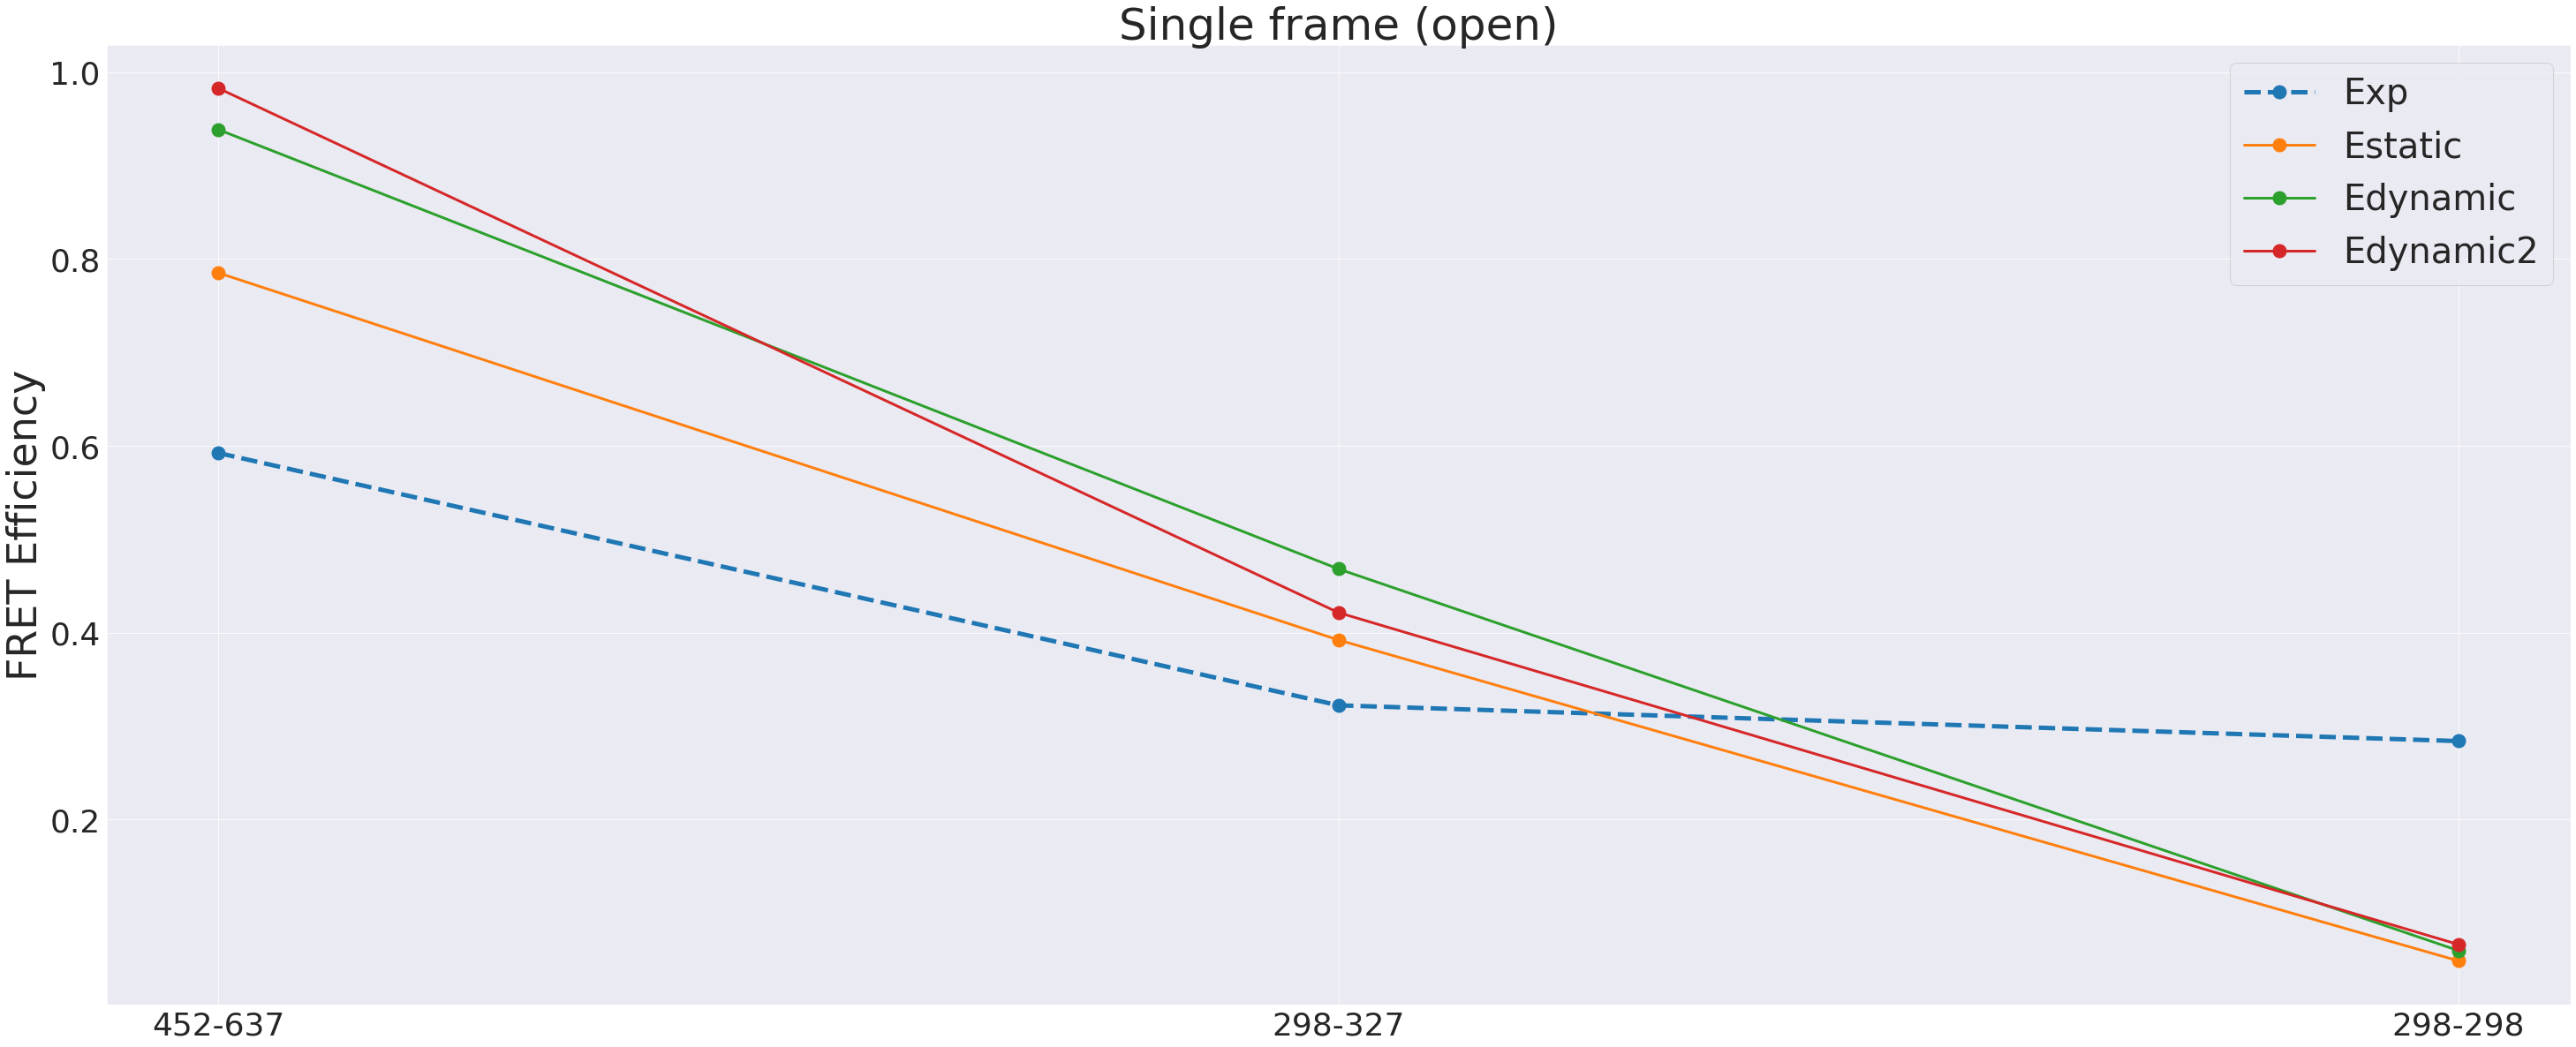

In [51]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(50, 20))

##############
# Single frame
##############

open_conf = results_pairs_df['conformation'] == 'open'

ax.errorbar(results_pairs_df[open_conf].index, results_pairs_df['Ex'].loc[open_conf], linewidth=5, 
               linestyle='dashed', marker='.', markersize=30, label='Exp');

ax.errorbar(results_pairs_df[open_conf].index, results_pairs_df['Es'].loc[open_conf], linewidth=3, marker='.', 
               markersize=30, label='Estatic');

ax.errorbar(results_pairs_df[open_conf].index, results_pairs_df['Ed'].loc[open_conf], linewidth=3, marker='.', 
               markersize=30, label='Edynamic');

ax.errorbar(results_pairs_df[open_conf].index, results_pairs_df['Ed2'].loc[open_conf], linewidth=3, marker='.', 
               markersize=30, label='Edynamic2');

# Tick labels size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(36)

# Legend
leg = ax.legend(prop={"size":40})

# Axis labels
ax.set_title('Single frame (open)', fontsize=50)
ax.set_xlabel('', fontsize=46)
ax.set_ylabel('FRET Efficiency', fontsize=46)

#### Closed Conformations

Text(0, 0.5, 'FRET Efficiency')

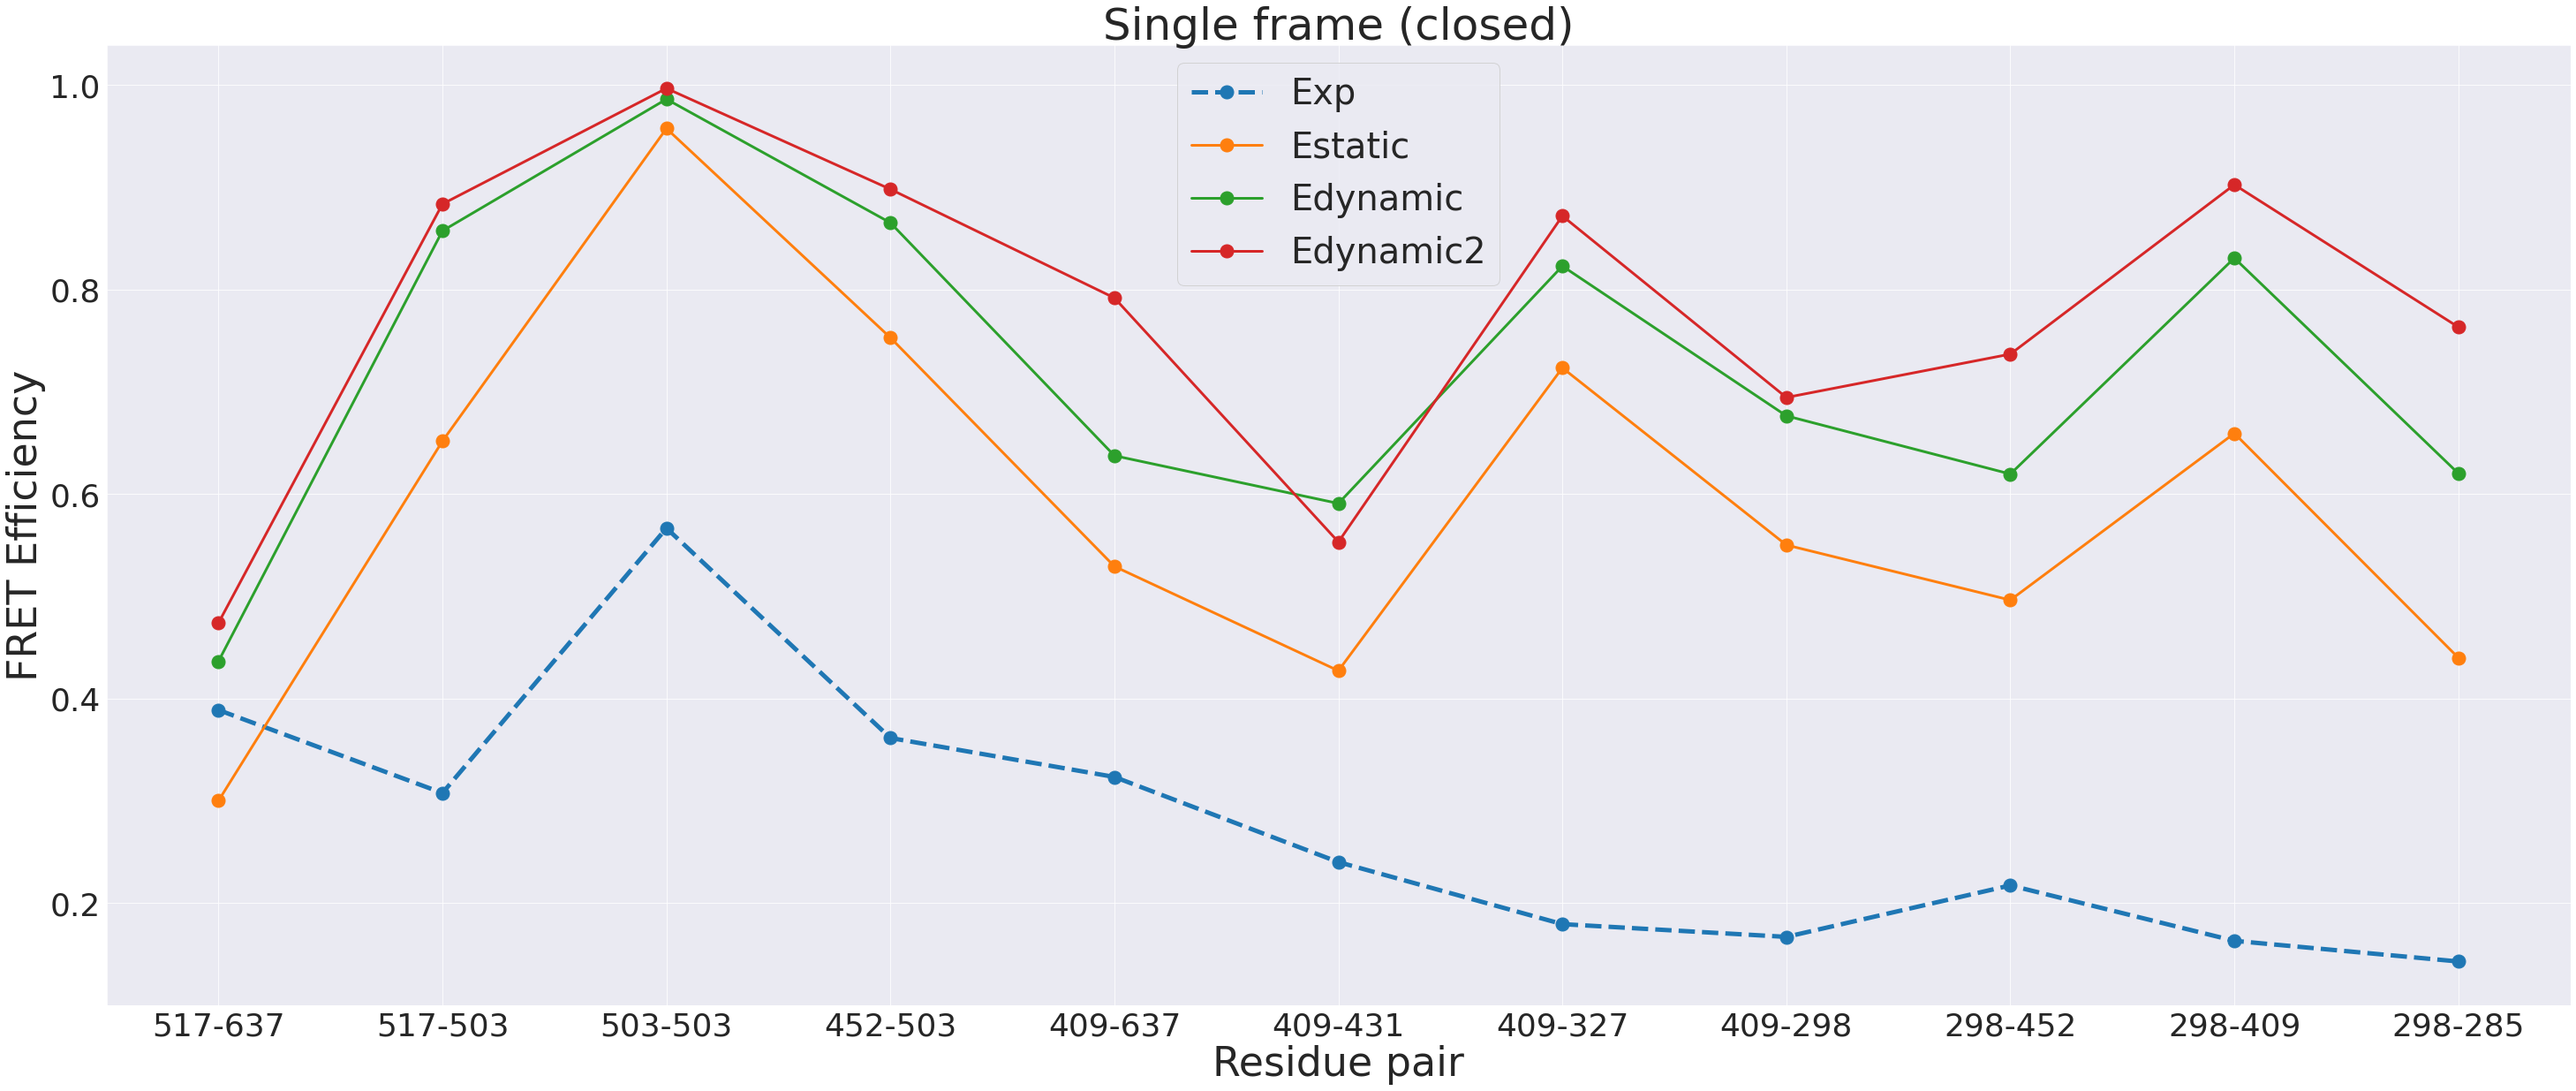

In [52]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(50, 20))

##############
# Single frame
##############

closed_conf = results_pairs_df['conformation'] == 'closed'

ax.errorbar(results_pairs_df[closed_conf].index, results_pairs_df['Ex'].loc[closed_conf], linewidth=5, 
               linestyle='dashed', marker='.', markersize=30, label='Exp');

ax.errorbar(results_pairs_df[closed_conf].index, results_pairs_df['Es'].loc[closed_conf], linewidth=3, marker='.', 
               markersize=30, label='Estatic');

ax.errorbar(results_pairs_df[closed_conf].index, results_pairs_df['Ed'].loc[closed_conf], linewidth=3, marker='.', 
               markersize=30, label='Edynamic');

ax.errorbar(results_pairs_df[closed_conf].index, results_pairs_df['Ed2'].loc[closed_conf], linewidth=3, marker='.', 
               markersize=30, label='Edynamic2');

# Tick labels size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(36)

# Legend
leg = ax.legend(prop={"size":40})

# Axis labels
ax.set_title('Single frame (closed)', fontsize=50)
ax.set_xlabel('Residue pair', fontsize=46)
ax.set_ylabel('FRET Efficiency', fontsize=46)

## Protein trajectory (open conformations)

### Sigle residue pair

Select residues to put the rotamer libraries on and the corresponding experimental data file.

In [13]:
res1 = 452
chain_res1 = 'A'
chromophore_1 = '532'

res2 = 637
chain_res2 = 'B'
chromophore_2 = '647'

exp_data_file = '452_532_637_647N_APO.txt'

Create universe for protein trajectory (3 frames)

In [14]:
u_traj = MDAnalysis.Universe('test_systems/Hsp90/average/conf.pdb', 'Hsp90_open_all.xtc')

Create instance of the FRETpredict class

In [15]:
cutoff = 10

# Scaling factors set to maximize agreement with <k^2> and <E>
sigma = 0.95
epsilon = 0.6

FRET = FRETpredict(protein=u_traj, residues=[res1, res2], temperature=293, chains=[chain_res1, chain_res2], 
                   r0=6.63, sigma_scaling=sigma, epsilon_scaling=epsilon, electrostatic=True,
                   libname_1='Alexa {} cutoff{:d}'.format(chromophore_1, cutoff),
                   libname_2='Alexa {} cutoff{:d}'.format(chromophore_2, cutoff), 
                   output_prefix='prova/E{:d}_{}_{}_traj'.format(cutoff, sigma, epsilon))

Run FRET Efficiency calculations

In [16]:
FRET.run()

Retrieve experimental data from file for the comparison

In [17]:
filename = 'test_systems/Hsp90/MDA/histograms/{}'.format(exp_data_file)

if os.path.isfile(filename):

        df = pd.read_csv(filename, skiprows=6, nrows=40, header=None, sep='\s+')
        Ex = np.average(df[0], weights=df[1])

Create DataFrame of the data 

In [18]:
results_traj = []

data_traj = pd.read_pickle(r'prova/E{:d}_{}_{}_traj-data-{:d}-{:d}.pkl'.format(cutoff, sigma, epsilon, res1, res2))
results_traj.append({'res': '{:d}-{:d}'.format(res1, res2),
                     'conformation': 'open',
                     'k2': data_traj.loc['k2', 'Average'],
                     'Ex': Ex,
                     'Es': data_traj.loc['Estatic', 'Average'],
                     'Ed': data_traj.loc['Edynamic1', 'Average'],
                     'Ed2': data_traj.loc['Edynamic2', 'Average'],
                     'chi2S': np.abs(Ex-data_traj.loc['Estatic', 'Average']),
                     'chi2D': np.abs(Ex-data_traj.loc['Edynamic1', 'Average']), 
                     'chi2D2': np.abs(Ex-data_traj.loc['Edynamic2', 'Average'])})
        
results_traj_df = pd.DataFrame(results_traj).set_index('res')

In [19]:
# Show results
results_traj_df

,conformation,k2,Ex,Es,Ed,Ed2,chi2S,chi2D,chi2D2
res,,,,,,,,,
452-637,open,0.901243,0.592377,0.783599,0.855561,0.865665,0.191222,0.263184,0.273288


### All residue pairs

Create universe for protein trajectory (only open conformations of Hsp90)

In [20]:
u_traj = MDAnalysis.Universe('test_systems/Hsp90/average/conf.pdb', 'Hsp90_open_all.xtc')

Create instance of the FRETpredict class, and run FRET efficiency calculations for every residue pair in the dictionary, for every trajectory frame. Save all the results in a DataFrame.

In [21]:
cutoff = 10

# Scaling factors set to maximize agreement with <k^2> and <E>
sigma = 0.95
epsilon = 0.6

results_traj_pairs = []

# Iterate on every residue pair
for i, _ in enumerate(exp_data['residue_pairs']): 
    
    # Calculate only for open conformations
    if exp_data['conformation'][i] == 'closed':
        
        continue
        
    elif exp_data['conformation'][i] == 'open':
        
        # Create instance of the FRETpredict class
        FRET = FRETpredict(protein=u_traj, residues=exp_data['residue_pairs'][i], temperature=293, 
                           chains=exp_data['residue_chains'][i], r0=exp_data['r0'][i], 
                           sigma_scaling=sigma, epsilon_scaling=epsilon, electrostatic=True,
                           libname_1='Alexa {} cutoff{:d}'.format(exp_data['chromophore_pairs'][i][0], cutoff),
                           libname_2='Alexa {} cutoff{:d}'.format(exp_data['chromophore_pairs'][i][1], cutoff), 
                           output_prefix='prova/E{:d}_{}_{}'.format(cutoff, sigma, epsilon))
    
        # Run FRET efficiency calculations
        FRET.run()
    
        # Recover experimental data from file
        filename = 'test_systems/Hsp90/MDA/histograms/{}'.format(exp_data['exp_data_files'][i])
    
        if os.path.isfile(filename):
        
            df = pd.read_csv(filename, skiprows=6, nrows=40, header=None, sep='\s+')
            Ex = np.average(df[0], weights=df[1])
    
        # Create a pandas.DataFrame with experimental and calculated FRET efficiencies, errors, Chi^2.
        data_traj_pairs = pd.read_pickle(r'prova/E{:d}_{}_{}-data-{:d}-{:d}.pkl'.format(cutoff, sigma, epsilon, 
                                                                         exp_data['residue_pairs'][i][0], 
                                                                         exp_data['residue_pairs'][i][1]))
    
        results_traj_pairs.append({'res': '{:d}-{:d}'.format(exp_data['residue_pairs'][i][0], 
                                                             exp_data['residue_pairs'][i][1]),
                                   'conformation': '{}'.format(exp_data['conformation'][i]),
                                   'k2': float(data_traj_pairs.loc['k2', 'Average']),
                                   'k2_err': float(data_traj_pairs.loc['k2', 'SE']),
                                   'Ex': Ex,
                                   'Es': float(data_traj_pairs.loc['Estatic', 'Average']),
                                   'Es_err': float(data_traj_pairs.loc['Estatic', 'SE']),
                                   'Ed': float(data_traj_pairs.loc['Edynamic1', 'Average']),
                                   'Ed_err': float(data_traj_pairs.loc['Edynamic1', 'SE']),
                                   'Ed2': float(data_traj_pairs.loc['Edynamic2', 'Average']),
                                   'Ed2_err': float(data_traj_pairs.loc['Edynamic2', 'SE']),
                                   'chi2S': np.abs(Ex-data_traj_pairs.loc['Estatic', 'Average']),
                                   'chi2D': np.abs(Ex-data_traj_pairs.loc['Edynamic1', 'Average']), 
                                   'chi2D2': np.abs(Ex-data_traj_pairs.loc['Edynamic2', 'Average'])})
    
results_traj_pairs_df = pd.DataFrame(results_traj_pairs).set_index('res')

In [22]:
# Show results
results_traj_pairs_df

,conformation,k2,k2_err,Ex,Es,Es_err,Ed,Ed_err,Ed2,Ed2_err,chi2S,chi2D,chi2D2
res,,,,,,,,,,,,,
452-637,open,0.901243,0.210809,0.592377,0.783599,0.123190,0.855561,0.103838,0.865665,0.108667,0.191222,0.263184,0.273288
298-327,open,0.122931,0.027768,0.322324,0.059047,0.020956,0.058493,0.022576,0.083578,0.026570,0.263277,0.263831,0.238746
298-298,open,0.261526,0.008295,0.284047,0.082847,0.023999,0.091874,0.029349,0.132956,0.045061,0.201200,0.192174,0.151091


## Plot results

Plot the comparison of the different FRET efficiency calculations with the experimental data available. For the trajectory analysis, errorbars are also reported.

#### Open Conformations

Text(0, 0.5, 'FRET Efficiency')

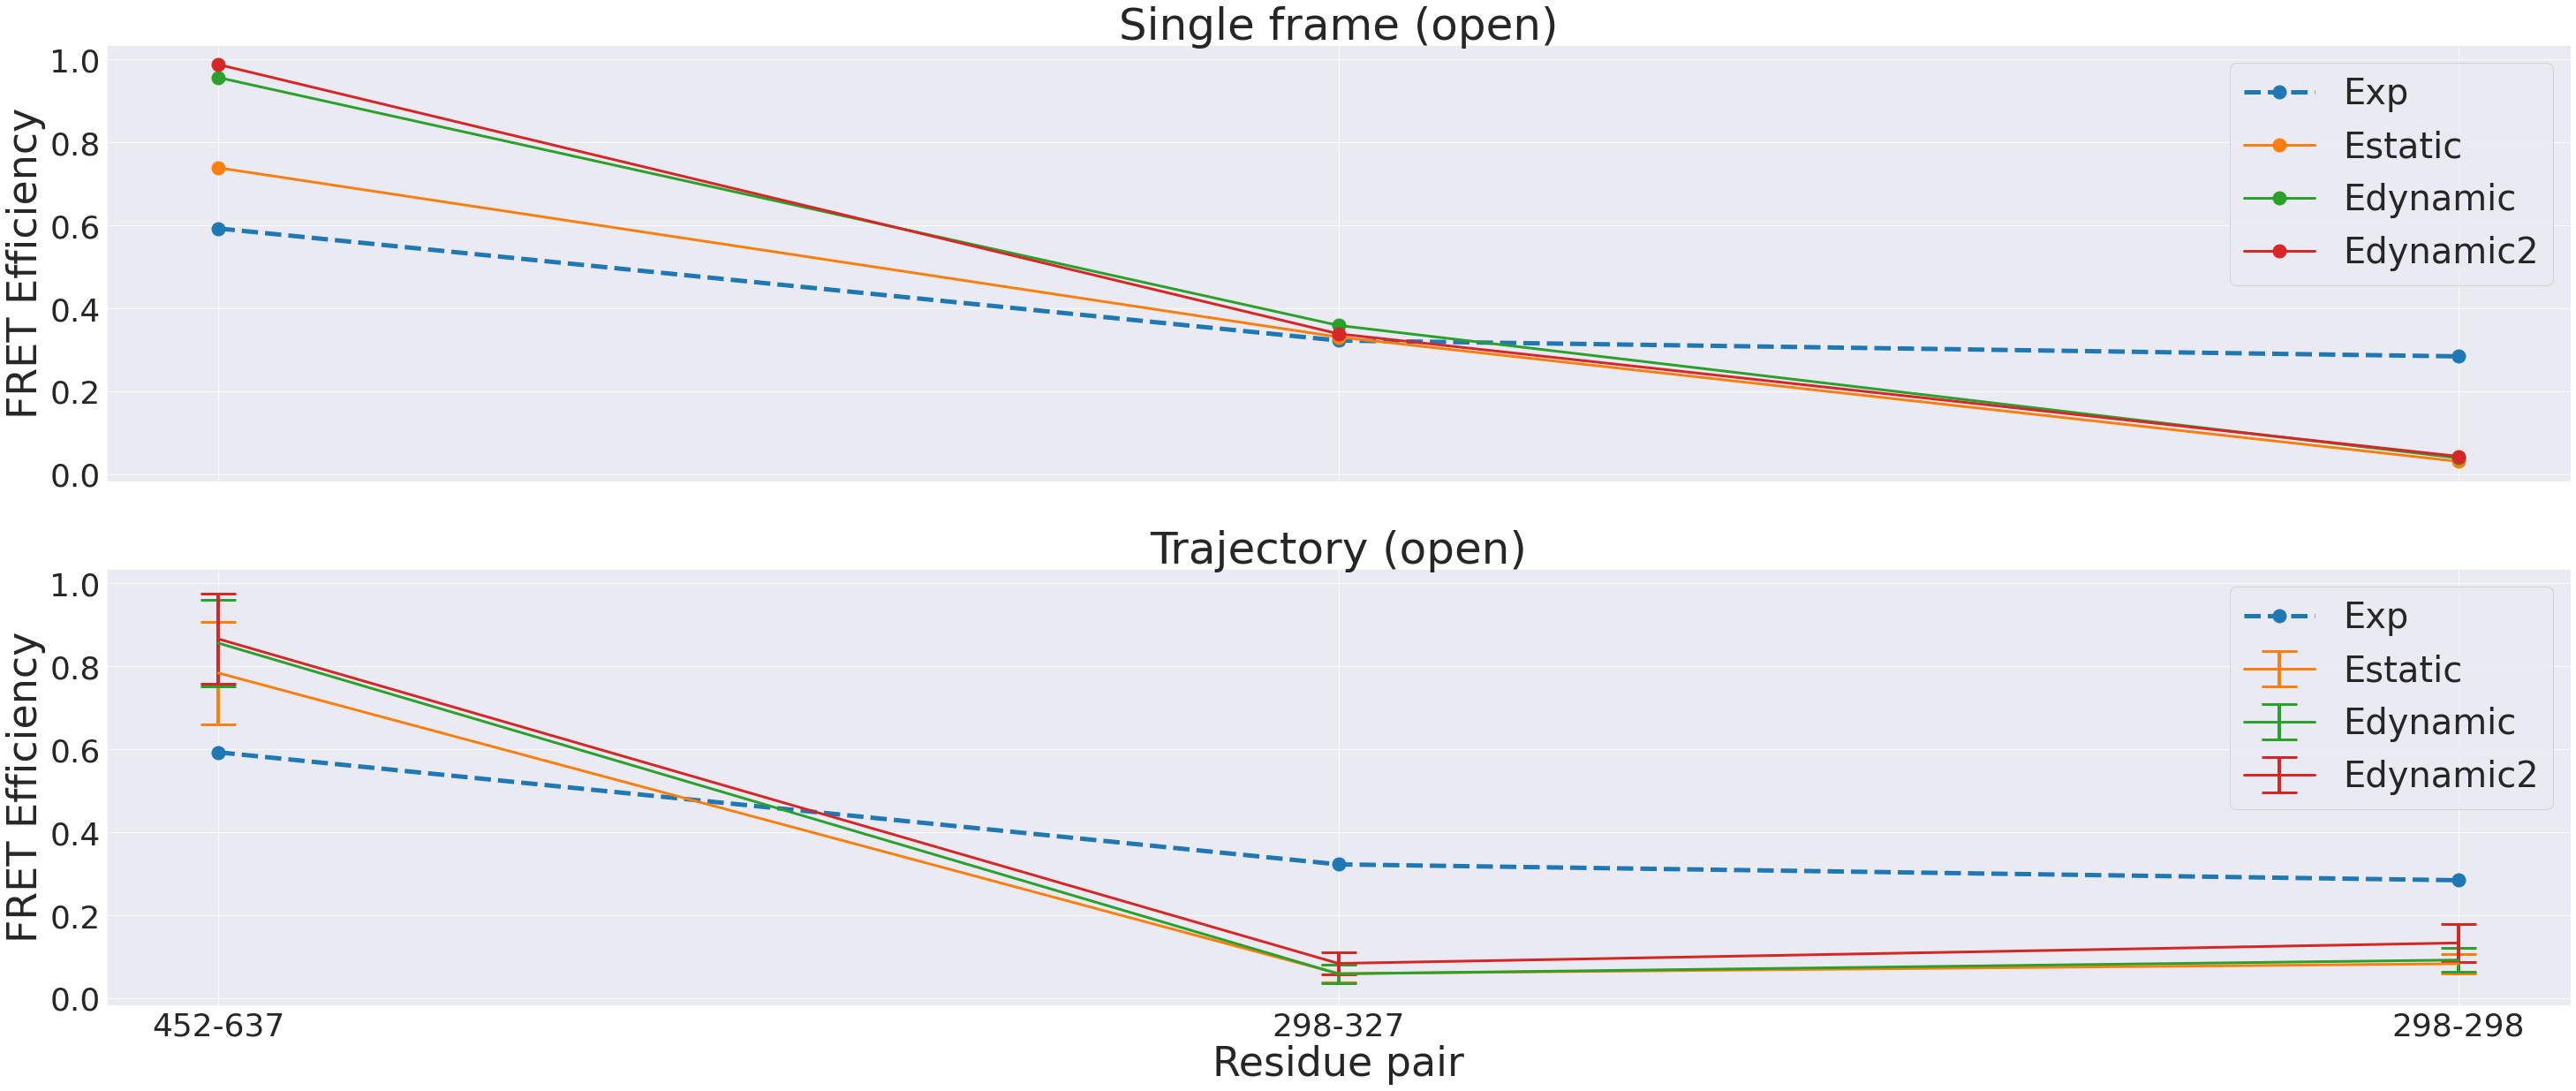

In [34]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(50, 20), nrows=2, sharey=True, sharex=True)

##############
# Single frame
##############

open_conf = results_pairs_df['conformation'] == 'open'

ax[0].errorbar(results_pairs_df[open_conf].index, results_pairs_df['Ex'].loc[open_conf], linewidth=5, 
               linestyle='dashed', marker='.', markersize=30, label='Exp');

ax[0].errorbar(results_pairs_df[open_conf].index, results_pairs_df['Es'].loc[open_conf], linewidth=3, marker='.', 
               markersize=30, label='Estatic');

ax[0].errorbar(results_pairs_df[open_conf].index, results_pairs_df['Ed'].loc[open_conf], linewidth=3, marker='.', 
               markersize=30, label='Edynamic');

ax[0].errorbar(results_pairs_df[open_conf].index, results_pairs_df['Ed2'].loc[open_conf], linewidth=3, marker='.', 
               markersize=30, label='Edynamic2');

# Tick labels size
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(36)

# Legend
leg = ax[0].legend(prop={"size":40})

# Axis labels
ax[0].set_title('Single frame (open)', fontsize=50)
ax[0].set_xlabel('', fontsize=46)
ax[0].set_ylabel('FRET Efficiency', fontsize=46)

############
# Trajectory
############

ax[1].errorbar(results_traj_pairs_df.index, results_traj_pairs_df['Ex'], linewidth=5, marker='.', 
                  markersize=30,linestyle='dashed', label='Exp');

ax[1].errorbar(results_traj_pairs_df.index, results_traj_pairs_df['Es'], yerr=results_traj_pairs_df['Es_err'], 
             capsize=20, capthick=3, elinewidth=4, linewidth=3, label='Estatic');

ax[1].errorbar(results_traj_pairs_df.index, results_traj_pairs_df['Ed'], yerr=results_traj_pairs_df['Ed_err'], 
             capsize=20, capthick=3, elinewidth=4, linewidth=3, label='Edynamic');

ax[1].errorbar(results_traj_pairs_df.index, results_traj_pairs_df['Ed2'], yerr=results_traj_pairs_df['Ed2_err'], 
             capsize=20, capthick=3, elinewidth=4, linewidth=3, label='Edynamic2');

# Tick labels size
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(36)

# Legend
leg = ax[1].legend(prop={"size":40})

# Axis labels
ax[1].set_title('Trajectory (open)', fontsize=50)
ax[1].set_xlabel('Residue pair', fontsize=46)
ax[1].set_ylabel('FRET Efficiency', fontsize=46)